Раскидывание данных для первого водителя по массивам:

In [1]:
%matplotlib inline
import pandas
import math
import matplotlib.pyplot as plt
import re
import datetime
import sort_coordinates

data = pandas.read_csv('data1.tsv', sep="\t")
debug = pandas.read_csv('debug1.tsv', sep="\t")
#debug[debug["hash"] == 86]
# names=['date', 'id', 'type', 'hash', 'latitude', 'longitude']
id_unique = data["id"].unique()
date_points = []
lat_points = []
lon_points = []
format_date = "%Y-%m-%d %H:%M:%S"

for i in id_unique:
    str_date = data[data["id"] == i]["date"].copy()
    datepstr = []
    for s in str_date:
        t = datetime.datetime.strptime(s, format_date)
        datepstr.append(t)
    date_points.append(datepstr)
    lat = sort_coordinates.del_invalid_idx(data[data["id"] == i]["latitude"].copy())
    lat_points.append(lat)
    lon = sort_coordinates.del_invalid_idx(data[data["id"] == i]["longitude"].copy())
    lon_points.append(lon)

Время так же важно. Между 1 и 2 временем значительно меньше времени, чем между 2 и 3. 
Соответственно нужно посмотреть на сколько большой/маленький отрезок пройден за время между точками. А значит нужно всё таки знать скорость.

In [2]:
speed = []
for j in range(len(lat_points) - 1):
    speed_hero = []
    for i in range(len(lat_points[j]) - 1):
        range_way = math.sqrt(math.pow(lat_points[j][i+1] - lat_points[j][i], 2)
                              + math.pow(lon_points[j][i+1] - lon_points[j][i], 2))
        range_time = (date_points[j][i + 1] - date_points[j][i]).total_seconds()
        speed_hero.append(range_way/range_time)
    speed.append(speed_hero)


In [3]:
import sort_coordinates

sort_speed = []

idx = 0

sort_lat = []
sort_lon = []
for i in range(len(speed)-1):
    temp_lat_points = sort_coordinates.del_invalid_idx(lat_points[i])
    temp_lon_points = sort_coordinates.del_invalid_idx(lon_points[i])
    lat = []
    lon = []
    sp = []
    temp_speed_array = speed[i].copy()
    while len(temp_speed_array) != 0:
        min_speed = 100000
        for i in range(len(temp_speed_array)-1):
            if min_speed > temp_speed_array[i]:
                min_speed = temp_speed_array[i]
                idx = i
        sp.append((idx, temp_speed_array.pop(idx)))
        lat.append((temp_lat_points.pop(idx), temp_lat_points[idx]))
        lon.append((temp_lon_points.pop(idx), temp_lon_points[idx]))
    sort_lat.append(lat)
    sort_lon.append(lon)
    sort_speed.append(sp)



Как отсортировать скорость сохраняя индекс вторым параметром?

Нужно понять какая скорость максимальная для остановок, чтобы решить какое кол-во точек, где тормозит водитель брать. Плюс нельзя забывать о том, что их в любом случае должно быть значительно больше так как светафоры/пробки...

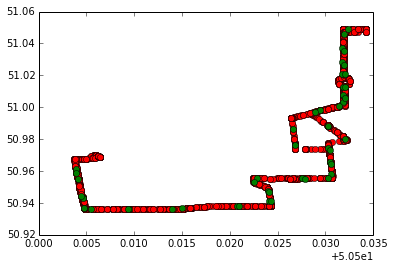

In [4]:
plt.plot(lat, lon, 'o', c = 'r')
plt.plot(debug["latitude"], debug["longitude"], 'o', c = 'g')

Нужно придумать как определять число остановок и предварительно разделить маршрут на 2 части - в одну и в другую сторону.

Можно основываясь на данных debug определить минимальную скорость для отрезка на котором находиться остановка.

Причём надо не индекс точки запоминать, а именно отрезки соединяющие эти точки.

Поиск первого круга:

In [5]:
import sort_coordinates

lat = []
lon = []
for i in range(len(lon_points)):
    print(i, "i")
    x, y = sort_coordinates.div_way(lat_points[i], lon_points[i]);
    for idx in range(len(x)):
        
        lat.append(x[idx])
        lon.append(y[idx])
# i = 6
# x = lat_points[i]
# y = lon_points[i]
# ways_x = []
# ways_y = []

# max_eps = 0.005
# i = 1
# f_point = 0
# for j in range(len(x) - 6):
#     idx = f_point+j+2
#     if idx + 3 >= len(x):
#         break
#     way_f = sort_coordinates.len_way(x[0], y[0], x[idx], y[idx])
#     idx = idx+1
#     way_s = sort_coordinates.len_way(x[0], y[0], x[idx], y[idx])
#     idx = idx+1
#     way_t = sort_coordinates.len_way(x[0], y[0], x[idx], y[idx])
#     if way_f > max_eps and  way_s > max_eps  and  way_t > max_eps:        
#         while 1:
#             idx = idx+1
#             if idx == len(x):
#                 idx = idx-1
#                 break
#             way_next = sort_coordinates.len_way(x[0], y[0], x[idx], y[idx])
#             if way_next < max_eps:
#                 idx = idx+1
#                 if idx == len(x):
#                     idx = idx-1
                    
#                 break
                
           
#         idx += 1
#         ways_x.append(x[f_point:idx])
#         ways_y.append(y[f_point:idx])
#         f_point = idx
#         if f_point + j + 6 >= len(x):
#             break
    
print("work")    

0 i
30 350
87 350
144 350
213 350
326 350
1 i
128 1105
341 1105
593 1105
982 1105
2 i
31 308
89 308
153 308
215 308
308 308
3 i
32 273
87 273
149 273
216 273
4 i
116 226
226 226
5 i
129 1021
361 1021
794 1021
6 i
134 1105
358 1105
591 1105
813 1105
1105 1105
7 i
101 1058
289 1058
528 1058
967 1058
8 i
31 608
100 608
209 608
380 608
559 608
9 i
117 221
221 221
work


Сравниваю расстояние между 3-мя стартовыми координатами и тремя следующими подраяд. Если max_eps > получаю конец круга.

30


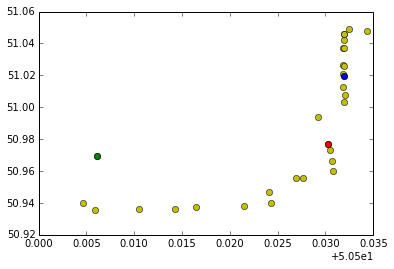

In [11]:
plt.plot(lat[0], lon[0], 'o', c = 'y')
#plt.plot(lat[0], lon[0], 'o', c = 'r')

i = 0
j = 0
plt.plot(lat[j][i], lon[j][i], 'o', c = 'g')
print (len(lat[j]))
i=len(lat[j])-1
plt.plot(lat[j][i], lon[j][i], 'o', c = 'b')
i=int((len(lat[j])-1)/2)
plt.plot(lat[j][i], lon[j][i], 'o', c = 'r')



В какой- то из версий практически идеально разделялись данные, потом я решила вынести код функции и теперь отделяется как-то по китайски.